In [49]:
import pandas as pd
import numpy as np
# show max columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from utils.exploration import *
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss, roc_auc_score

## Read Data

In [50]:
df_raw = pd.read_csv('Data\SEER_Final_Data_vf1_cleaned.csv')

In [51]:
df = df_raw.copy()

In [52]:
display(df.head(3), df.shape)

,Patient ID,Histologic Type ICD-O-3,Year of diagnosis,Sex,Race,Radiation recode,Bone Metastasis,Brain Metastasis,Liver Metastasis,Lung Metastasis,T,N,M,Grouped Stage,Chemotherapy,Tumor Size,Surgery,Age,Survival Months,Survival Months Group
0,194350,0,2010,Female,Black,1,0,0,0,0,T4,N1,M1,IV,1,46,0,75-79 years,14,12-24 months
1,674026,0,2010,Female,White,0,0,0,0,0,T2,N2,M0,III,1,50,0,60-64 years,66,Over 24 months
2,462906,0,2010,Female,White,1,1,1,0,1,T4,N2,M1,IV,1,70,0,70-74 years,2,0-12 months


(28882, 20)

In [53]:
df['Survival Months'].describe()

count    28882.000000
mean         9.672876
std         11.455663
min          0.000000
25%          2.000000
50%          7.000000
75%         13.000000
max        128.000000
Name: Survival Months, dtype: float64

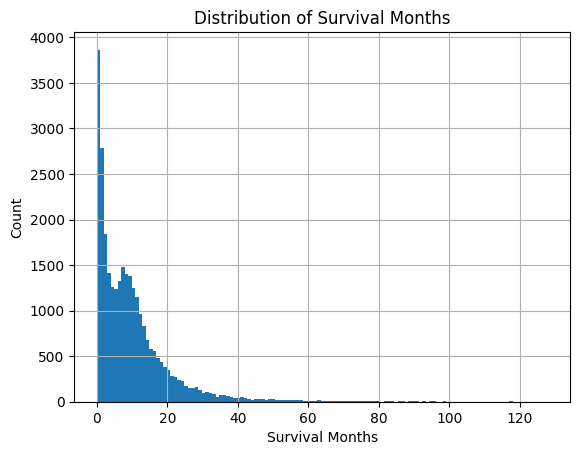

In [54]:
df['Survival Months'].hist(bins=129)
plt.xlabel('Survival Months')
plt.ylabel('Count')
plt.title('Distribution of Survival Months')
plt.show()

In [7]:
# Define the bins and labels
bins = [0, 12, float('inf')]  
labels = ['0-12 months', 'Over 12 months']

# Use pd.cut to create the new column
df['Grouped Survival Months'] = pd.cut(df['Survival Months'], bins=bins, labels=labels, right=False)

df['Survival Months Group'] = df['Grouped Survival Months'].astype('category')

# drop the old column
df.drop(columns='Grouped Survival Months', inplace=True)
df.drop(columns='Survival Months', inplace=True)

In [8]:
df['Histologic Type ICD-O-3'].value_counts(dropna=False)

Histologic Type ICD-O-3
0    28325
1      557
Name: count, dtype: int64

In [9]:
# drop df['Histologic Type ICD-O-3'] = 0
df = df[df['Histologic Type ICD-O-3'] != 0]

# drop the df['Histologic Type ICD-O-3']
df.drop(columns='Histologic Type ICD-O-3', inplace=True)

Counts and percentages of unique values in Survival Months Group:
                       Count  Percentage
Survival Months Group                   
0-12 months              340   61.041293
Over 12 months           217   38.958707


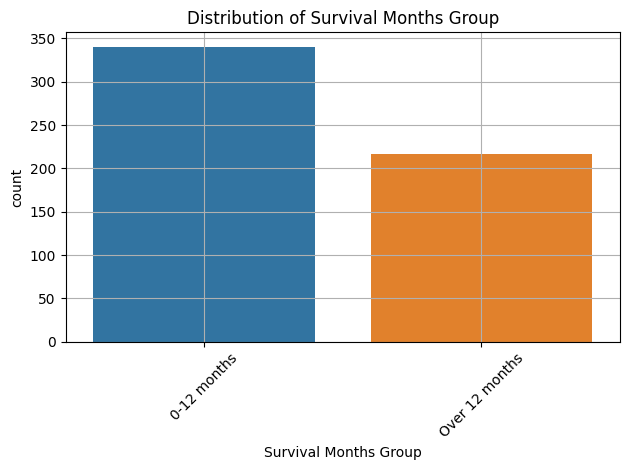

In [10]:
data_exploration(df, 'Survival Months Group')

## Data Preprocessing

In [11]:
# check missing values
df.isnull().sum()

Patient ID               0
Year of diagnosis        0
Sex                      0
Race                     0
Radiation recode         0
Bone Metastasis          0
Brain Metastasis         0
Liver Metastasis         0
Lung Metastasis          0
T                        0
N                        0
M                        0
Grouped Stage            0
Chemotherapy             0
Tumor Size               0
Surgery                  0
Age                      0
Survival Months Group    0
dtype: int64

In [12]:
# drop Year of diagnosis, Patient ID
df.drop(columns=['Year of diagnosis', 'Patient ID'], inplace=True)

In [13]:
df['Sex'].value_counts(dropna=False)

Sex
Male      307
Female    250
Name: count, dtype: int64

In [14]:
df['Sex'] = df['Sex'].map({'Female': 0, 'Male': 1})

In [15]:
df['Race'].value_counts(dropna=False) # we will do one hot encoding later

Race
White    466
Black     59
Other     32
Name: count, dtype: int64

In [16]:
df['Radiation recode'].value_counts(dropna=False)

Radiation recode
0    304
1    253
Name: count, dtype: int64

In [17]:
df['Bone Metastasis'].value_counts(dropna=False)

Bone Metastasis
0    454
1    103
Name: count, dtype: int64

In [18]:
df['T'].value_counts(dropna=False) # we will do one hot encoding on T N M Stage later

T
T2    168
T4    141
T3    129
T1    119
Name: count, dtype: int64

In [19]:
df['Chemotherapy'].value_counts(dropna=False)

Chemotherapy
1    386
0    171
Name: count, dtype: int64

In [20]:
df['Surgery'].value_counts(dropna=False)

Surgery
0    331
1    226
Name: count, dtype: int64

In [21]:
df['Age'].value_counts(dropna=False)

Age
65-69 years    118
70-74 years    108
75-79 years     82
60-64 years     75
55-59 years     61
80-84 years     50
85+ years       28
50-54 years     21
45-49 years     12
20-44 years      2
Name: count, dtype: int64

In [22]:
df.dtypes

Sex                         int64
Race                       object
Radiation recode            int64
Bone Metastasis             int64
Brain Metastasis            int64
Liver Metastasis            int64
Lung Metastasis             int64
T                          object
N                          object
M                          object
Grouped Stage              object
Chemotherapy                int64
Tumor Size                  int64
Surgery                     int64
Age                        object
Survival Months Group    category
dtype: object

In [23]:
# a loop to convert all object columns to category
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [24]:
df.dtypes

Sex                         int64
Race                     category
Radiation recode            int64
Bone Metastasis             int64
Brain Metastasis            int64
Liver Metastasis            int64
Lung Metastasis             int64
T                        category
N                        category
M                        category
Grouped Stage            category
Chemotherapy                int64
Tumor Size                  int64
Surgery                     int64
Age                      category
Survival Months Group    category
dtype: object

## Modeling

| Models                         | Normalization of Numeric Columns? | Directly Handle Categorical Columns? | Linear Assumptions and Correlations? | Output Probabilities? |
|--------------------------------|-----------------------------------|-------------------------------------|--------------------------------------|-----------------------|
| Decision Trees and Random Forests | No                              | Yes                                 | No                                   | Yes                   |
| Gradient Boosting Machines (XGBoost, LightGBM) | Not necessary, but can be beneficial | Yes                             | No                                   | Yes                   |
| Support Vector Machines (SVM)  | Yes                              | No                                  | Yes (for linear kernel)              | Yes (with probability estimates enabled) |
| k-Nearest Neighbors (k-NN)     | Yes                              | No (requires one-hot or similar encoding) | No                               | Yes                   |
| Neural Networks                | Yes                              | No (requires one-hot or similar encoding) | No                               | Yes                   |
| Logistic Regression            | Yes                              | No (requires one-hot encoding)      | Yes                                  | Yes                   |


So for the sufficiency of the data, we can use the following models: 
- Decision Trees and Random Forests
- Gradient Boosting Machines (XGBoost, LightGBM)


## Tree-based Models

In [25]:
df_t = df.copy()

In [26]:


# binarize the target variable {'0-12 months': 1, 'Over 12 months': 0}
df_t['Survival Months Group'] = df_t['Survival Months Group'].map({'0-12 months': 1, 'Over 12 months': 0})

# set it to int
df_t['Survival Months Group'] = df_t['Survival Months Group'].astype(int)

df_t['Survival Months Group'].value_counts(dropna=False)

Survival Months Group
1    340
0    217
Name: count, dtype: int64

In [27]:
# split the data into train and test
from sklearn.model_selection import train_test_split

X = df_t.drop(columns='Survival Months Group')
y = df_t['Survival Months Group']

categorical_features = [col for col in X.columns if X[col].dtype == 'category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# check the shape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f'Catgorical features: {categorical_features}')

(445, 15) (112, 15) (445,) (112,)
Catgorical features: ['Race', 'T', 'N', 'M', 'Grouped Stage', 'Age']


### Decision Tree

In [28]:
# one hot encoding for categorical variables only
from sklearn.preprocessing import OneHotEncoder

X_train_ohe= pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# loop to change boolean columns to int
for col in X_train_ohe.columns:
    if X_train_ohe[col].dtype == 'bool':
        X_train_ohe[col] = X_train_ohe[col].astype('int')
        X_test_ohe[col] = X_test_ohe[col].astype('int')

for col in X_test_ohe.columns:
    if X_test_ohe[col].dtype == 'bool':
        X_train_ohe[col] = X_train_ohe[col].astype('int')
        X_test_ohe[col] = X_test_ohe[col].astype('int')

# check the shape
print(X_train_ohe.shape, X_test_ohe.shape, y_train.shape, y_test.shape)

(445, 30) (112, 30) (445,) (112,)


In [29]:
from sklearn.metrics import fbeta_score, make_scorer
# Custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# build a decision tree classifier
# Define the parameter grid
param_dist = {
    'max_depth': range(3, 21),
    'min_samples_leaf': range(1, 40),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': np.linspace(0, 1, 100)
}

# Decision Tree classifier
dt = DecisionTreeClassifier()

# Random search with cross-validation
random_search = RandomizedSearchCV(dt, param_dist, n_iter=200, scoring=f2_scorer, cv=10, random_state=123)

# Fit the model
random_search.fit(X_train_ohe, y_train)


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=200,
                   param_distributions={'ccp_alpha': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222...
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(3, 21),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': range(1, 40)},
                   random_state=123,
                   scoring=make_scorer(fbeta_score, beta=2, average=weighted))

In [47]:
# print the best parameters
print(random_search.best_params_)

{'min_samples_leaf': 17, 'max_features': None, 'max_depth': 14, 'criterion': 'entropy', 'ccp_alpha': 0.020202020202020204}


Result

In [48]:
# predict on the test set
y_pred = random_search.predict(X_test_ohe)

# print the train and test scores, confusion matrix, classification report
print(f'Train score: {random_search.best_score_:.4f}')
print(f'Test score: {random_search.score(X_test_ohe, y_test):.4f}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train score: 0.7098
Test score: 0.7326
[[31 13]
 [17 51]]
              precision    recall  f1-score   support

           0       0.65      0.70      0.67        44
           1       0.80      0.75      0.77        68

    accuracy                           0.73       112
   macro avg       0.72      0.73      0.72       112
weighted avg       0.74      0.73      0.73       112



In [33]:
# ROC AUC score
print(f'ROC AUC score: {roc_auc_score(y_test, y_pred):.4f}')

ROC AUC score: 0.7640


Select important features

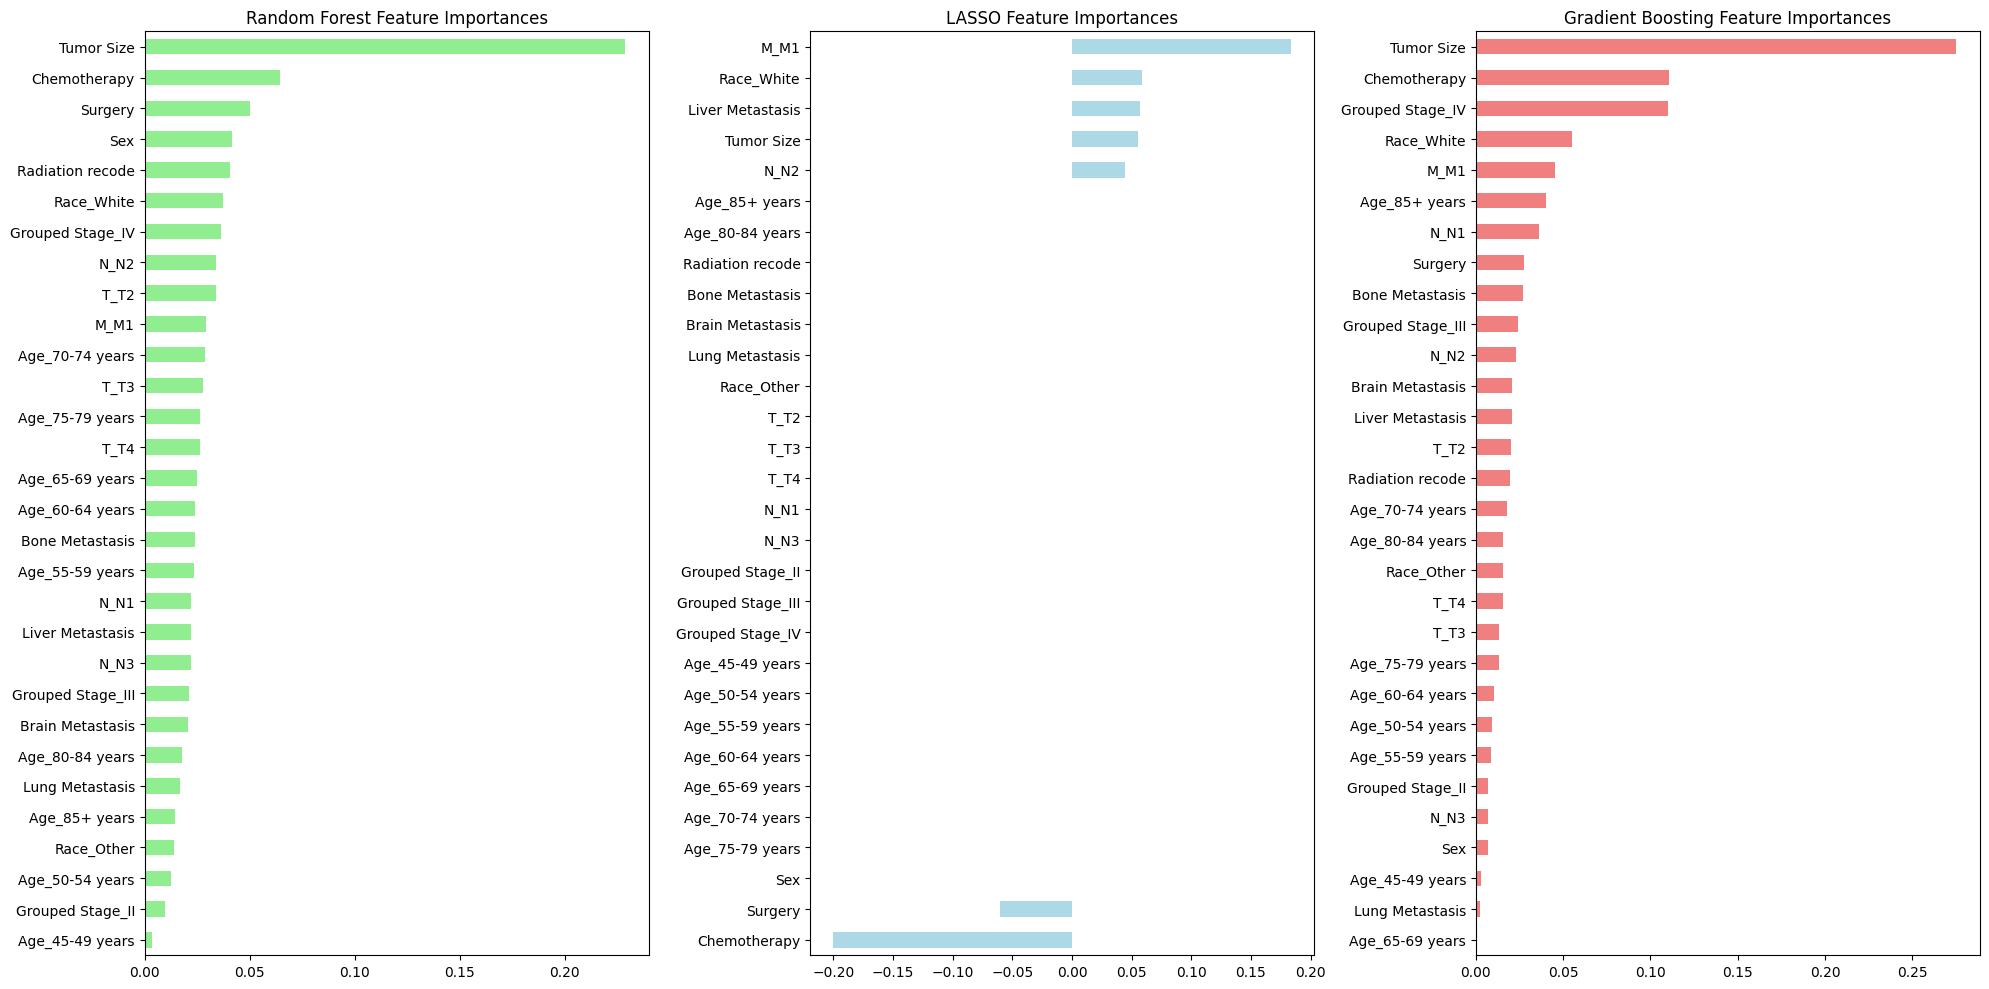

In [34]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LassoCV

# RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_ohe, y_train)
feature_importances_rf = pd.Series(data=rf_clf.feature_importances_, index=X_train_ohe.columns)

# LassoCV
lasso = LassoCV(cv=5)  # Assuming a 5-fold cross-validation
X_train_ohe_std = X_train_ohe.copy()
# Standardize the 'Tumor Size' column
X_train_ohe_std['Tumor Size'] = (X_train_ohe['Tumor Size'] - X_train_ohe['Tumor Size'].mean()) / X_train_ohe['Tumor Size'].std()
lasso.fit(X_train_ohe_std, y_train)
feature_importances_lasso = pd.Series(data=lasso.coef_, index=X_train_ohe.columns)

# GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_ohe, y_train)
feature_importances_gb = pd.Series(data=gbc.feature_importances_, index=X_train_ohe.columns)

# Sorting feature importances
importances_sorted_rf = feature_importances_rf.sort_values()
importances_sorted_lasso = feature_importances_lasso.sort_values()
importances_sorted_gb = feature_importances_gb.sort_values()

# Creating subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Plotting feature importances
importances_sorted_rf.plot(kind='barh', color='lightgreen', ax=axs[0])
axs[0].set_title('Random Forest Feature Importances')

importances_sorted_lasso.plot(kind='barh', color='lightblue', ax=axs[1])
axs[1].set_title('LASSO Feature Importances')

importances_sorted_gb.plot(kind='barh', color='lightcoral', ax=axs[2])
axs[2].set_title('Gradient Boosting Feature Importances')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [35]:
# Random Forest - Top 15
top_features_rf = importances_sorted_rf.nlargest(10).index.tolist()

# LassoCV - Top 7 (consider absolute values)
top_features_lasso = feature_importances_lasso.abs().nlargest(10).index.tolist()

# Gradient Boosting - Top 15
top_features_gb = importances_sorted_gb.nlargest(10).index.tolist()

# SelectKBest - Top 10
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=10)
selector.fit(X_train_ohe_std, y_train)
top_features_kbest = X_train_ohe_std.columns[selector.get_support(indices=True)].tolist()

In [36]:
# Combine all important features
all_important_features = set(top_features_rf + top_features_lasso + top_features_gb + top_features_kbest)

# Find consistently important features
consistently_important_features = set(top_features_rf).intersection(top_features_lasso, top_features_gb, top_features_kbest)

# Print results
print("All Important Features:", all_important_features)
print("Consistently Important Features:", consistently_important_features)

All Important Features: {'Grouped Stage_IV', 'Tumor Size', 'T_T2', 'Bone Metastasis', 'Brain Metastasis', 'Sex', 'Surgery', 'Radiation recode', 'Liver Metastasis', 'N_N2', 'Age_85+ years', 'M_M1', 'Chemotherapy', 'Grouped Stage_III', 'N_N1', 'T_T4', 'Lung Metastasis', 'Race_White'}
Consistently Important Features: {'M_M1', 'Surgery', 'Chemotherapy', 'Tumor Size'}


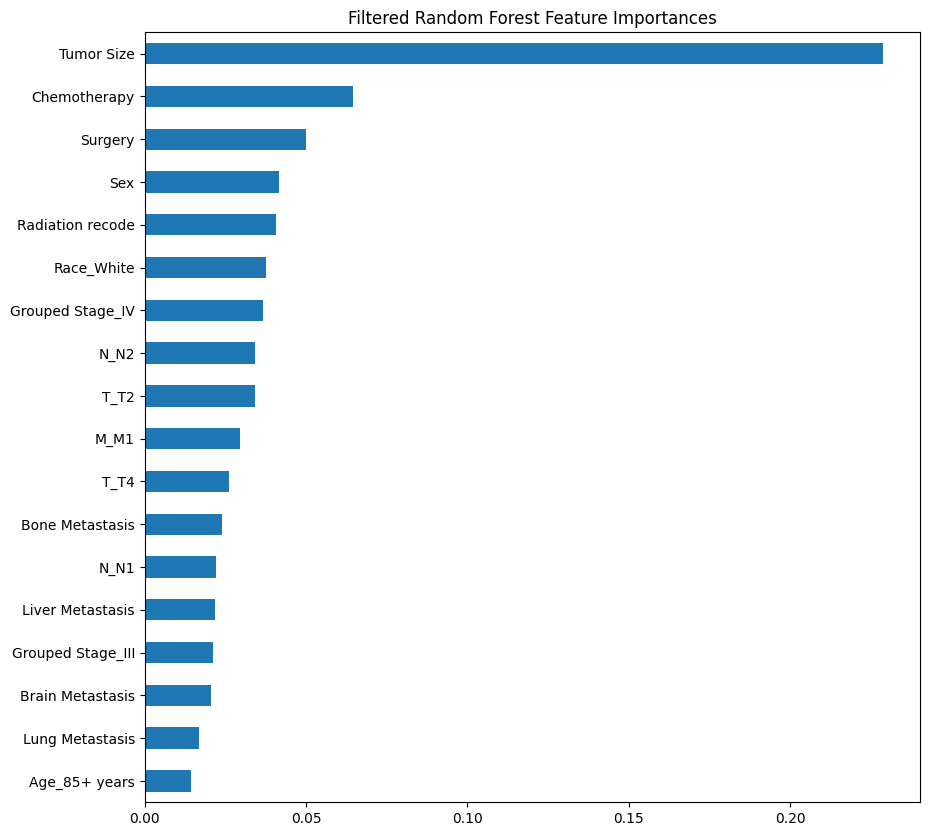

In [37]:
# Viualize the filtered feature importances
importances_filtered_rf = feature_importances_rf[feature_importances_rf.index.isin(all_important_features)]
importances_sorted_rf = importances_filtered_rf.sort_values()

plt.figure(figsize=(10, 10))
importances_sorted_rf.plot(kind='barh')
plt.title('Filtered Random Forest Feature Importances')
plt.show()

### Decision Tree with selected features

In [38]:
# retrain the model with the filtered features
important_features_list = list(all_important_features)
X_train_filtered = X_train_ohe[important_features_list]
X_test_filtered = X_test_ohe[important_features_list]

# print the shape of the filtered train and test set
print(X_train_filtered.shape)
print(X_test_filtered.shape)

(445, 18)
(112, 18)


In [39]:
# Define the parameter grid
param_dist = {
    'max_depth': range(3, 21),
    'min_samples_leaf': range(1, 40),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': np.linspace(0, 1, 100)
}

# Decision Tree classifier
dt2 = DecisionTreeClassifier()

# Random search with cross-validation
random_search2 = RandomizedSearchCV(dt2, param_dist, n_iter=200, scoring=f2_scorer, cv=10, random_state=123)

# Fit the model
random_search2.fit(X_train_filtered, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=200,
                   param_distributions={'ccp_alpha': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222...
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(3, 21),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': range(1, 40)},
                   random_state=123,
                   scoring=make_scorer(fbeta_score, beta=2, average=weighted))

In [40]:
# print the best parameters
print(random_search2.best_params_)
# predict on the test set
y_pred2 = random_search2.predict(X_test_filtered)

{'min_samples_leaf': 17, 'max_features': None, 'max_depth': 14, 'criterion': 'entropy', 'ccp_alpha': 0.020202020202020204}


Result

In [41]:
# print the train and test scores, confusion matrix, classification report
print(f'Train score: {random_search2.best_score_:.4f}')
print(f'Test score: {random_search2.score(X_test_filtered, y_test):.4f}')
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))


Train score: 0.7098
Test score: 0.7326
[[31 13]
 [17 51]]
              precision    recall  f1-score   support

           0       0.65      0.70      0.67        44
           1       0.80      0.75      0.77        68

    accuracy                           0.73       112
   macro avg       0.72      0.73      0.72       112
weighted avg       0.74      0.73      0.73       112



### Random Forest

In [42]:
# build a random forest classifier
# Define the parameter grid
param_dist = {
    'n_estimators': range(100, 1001, 100),
    'max_depth': range(3, 21),
    'min_samples_leaf': range(1, 40),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': np.linspace(0, 1, 100)
}

# Random Forest classifier
rf = RandomForestClassifier()

# Random search with cross-validation
random_search1 = RandomizedSearchCV(rf, param_dist, n_iter=100, scoring=f2_scorer, cv=10, random_state=123)

# Fit the model
random_search1.fit(X_train_ohe, y_train) # 8mins

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'ccp_alpha': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222...
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(3, 21),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': range(1, 40),
                                        'n_estimators': range(100, 1001, 100)},
                   random_state=123,
                   scoring=make_scorer(fbeta_score, beta=2, average=weighted))

In [43]:
# print the best parameters
print(random_search1.best_params_)
# predict on the test set
y_pred = random_search1.predict(X_test_ohe)

{'n_estimators': 800, 'min_samples_leaf': 17, 'max_features': 'log2', 'max_depth': 19, 'criterion': 'entropy', 'ccp_alpha': 0.0}


Result

In [44]:
# print the train and test scores, confusion matrix, classification report
print(f'Train score: {random_search1.best_score_:.4f}')
print(f'Test score: {random_search1.score(X_test_ohe, y_test):.4f}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train score: 0.7040
Test score: 0.7300
[[26 18]
 [12 56]]
              precision    recall  f1-score   support

           0       0.68      0.59      0.63        44
           1       0.76      0.82      0.79        68

    accuracy                           0.73       112
   macro avg       0.72      0.71      0.71       112
weighted avg       0.73      0.73      0.73       112



### Catboost

In [83]:
# build a catboost classifier
from catboost import CatBoostClassifier

# Parameter grid for RandomizedSearchCV
param_dist = {
    "iterations": np.arange(100, 401, 50),
    "learning_rate": np.logspace(np.log10(1e-3), np.log10(0.1), num=20),
    "depth": np.arange(1, 16, 1),
    "subsample": np.linspace(0.05, 1.0, num=20),
    "colsample_bylevel": np.linspace(0.05, 1.0, num=20),
    "min_data_in_leaf": np.arange(2, 40, 1)
}

# CatBoost Classifier
catboost_model = CatBoostClassifier(verbose=False, random_state=123, cat_features=categorical_features)

# RandomizedSearchCV
random_search3 = RandomizedSearchCV(
    catboost_model, param_distributions=param_dist, n_iter=50, 
    scoring=f2_scorer, cv=3, random_state=123, verbose=False
)

# Fit the model
random_search3.fit(X_train, y_train) # 42mins

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000012523484210>,
                   n_iter=50,
                   param_distributions={'colsample_bylevel': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'iterations': array([100, 150, 200, 250, 300, 350, 400]),
                                        'le...
       0.0379269 , 0.0483293 , 0.06158482, 0.078476  , 0.1       ]),
                                        'min_data_in_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39]),
                                        'subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   random_state=123,
                   scoring=make_scorer(fbeta_score, beta=2, average=weighted),
                   verbose=False)

In [84]:
# print the best parameters
print(random_search3.best_params_)
# predict on the test set
y_pred3 = random_search3.predict(X_test)

{'subsample': 0.15, 'min_data_in_leaf': 16, 'learning_rate': 0.0379269019073225, 'iterations': 150, 'depth': 12, 'colsample_bylevel': 0.9}


Result

In [85]:
# print the train and test scores, confusion matrix, classification report
print(f'Train score: {random_search3.best_score_:.4f}')
print(f'Test score: {random_search3.score(X_test, y_test):.4f}')
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))


Train score: 0.7105
Test score: 0.7300
[[26 18]
 [12 56]]
              precision    recall  f1-score   support

           0       0.68      0.59      0.63        44
           1       0.76      0.82      0.79        68

    accuracy                           0.73       112
   macro avg       0.72      0.71      0.71       112
weighted avg       0.73      0.73      0.73       112



### Lightgbm

In [109]:
# label encode the Age column
from sklearn.preprocessing import LabelEncoder
age_le = LabelEncoder()
X_train['Age'] = age_le.fit_transform(X_train['Age'])
X_test['Age'] = age_le.transform(X_test['Age'])

# label encode the Stage Group column
stage_le = LabelEncoder()
X_train['Grouped Stage'] = stage_le.fit_transform(X_train['Grouped Stage'])
X_test['Grouped Stage'] = stage_le.transform(X_test['Grouped Stage'])

In [113]:
from optuna.integration.lightgbm import LightGBMTunerCV as lgbtcv
from lightgbm import early_stopping
import optuna
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
from lightgbm import Dataset as lgbDataset
from sklearn.metrics import fbeta_score

In [114]:
# Define the custom F2 evaluation function
def lgb_f2_eval(preds, data):
    labels = data.get_label()
    preds = np.round(preds)
    return 'lgb_f2_eval', -fbeta_score(labels, preds, beta=2), False  # Return the negative F2 score


In [119]:
# Parameters for LightGBM for multiclass classification
params = {
    "objective": "binary",  # Objective for multiclass classification
    "metric": "lgb_f2_eval",  # Use custom metric
    "boosting_type": "gbdt",
    "verbosity": -1,
}

# Create LightGBM dataset (assuming X1_a_train and y1_a_train are defined)
dtrain = lgbDataset(X_train, label=y_train, categorical_feature=categorical_features)

# Create an Optuna study object
study_auto_lgb = optuna.create_study(direction='minimize', study_name='LightGBM Tuner CV for Survival Months')

# Perform cross-validation with Optuna
auto_lgb_tuner = lgbtcv(
    params=params, 
    train_set=dtrain,  
    num_boost_round=200,  # Number of boosting iterations
    nfold=5,  
    stratified=True,  # Perform stratified sampling
    seed=123,  # Fix random seed for reproducibility of cv
    optuna_seed=123,  # Fix random seed for reproducibility of optuna trials
    shuffle=True,  # Shuffle data before creating folds
    callbacks=[early_stopping(10)],
    study=study_auto_lgb,
    feval=lgb_f2_eval
)

auto_lgb_tuner.run()


feature_fraction, val_score: -0.887135:  14%|#4        | 1/7 [00:00<00:00,  8.07it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: -0.887135:  43%|####2     | 3/7 [00:00<00:00,  7.74it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: -0.887135:  71%|#######1  | 5/7 [00:00<00:00,  7.67it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: -0.887135: 100%|##########| 7/7 [00:00<00:00,  7.71it/s]


Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317


num_leaves, val_score: -0.887135:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:   5%|5         | 1/20 [00:00<00:02,  8.17it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  10%|#         | 2/20 [00:00<00:02,  7.55it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  15%|#5        | 3/20 [00:00<00:02,  7.44it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  20%|##        | 4/20 [00:00<00:02,  7.62it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  25%|##5       | 5/20 [00:00<00:01,  8.09it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  30%|###       | 6/20 [00:00<00:01,  7.73it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  35%|###5      | 7/20 [00:00<00:01,  7.34it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  40%|####      | 8/20 [00:01<00:01,  7.37it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  45%|####5     | 9/20 [00:01<00:01,  7.76it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  50%|#####     | 10/20 [00:01<00:01,  7.68it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  55%|#####5    | 11/20 [00:01<00:01,  7.82it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  60%|######    | 12/20 [00:01<00:01,  7.83it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  65%|######5   | 13/20 [00:01<00:00,  7.57it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  70%|#######   | 14/20 [00:01<00:00,  7.23it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  75%|#######5  | 15/20 [00:02<00:00,  7.09it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  80%|########  | 16/20 [00:02<00:00,  7.26it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  85%|########5 | 17/20 [00:02<00:00,  7.37it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  90%|######### | 18/20 [00:02<00:00,  7.45it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135:  95%|#########5| 19/20 [00:02<00:00,  7.29it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: -0.887135: 100%|##########| 20/20 [00:02<00:00,  7.51it/s]


Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317


bagging, val_score: -0.887135:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds


bagging, val_score: -0.888294:  10%|#         | 1/10 [00:00<00:01,  6.57it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


bagging, val_score: -0.888294:  20%|##        | 2/10 [00:00<00:01,  7.32it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


bagging, val_score: -0.888294:  30%|###       | 3/10 [00:00<00:00,  7.76it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


bagging, val_score: -0.888294:  40%|####      | 4/10 [00:00<00:00,  7.03it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


bagging, val_score: -0.888294:  50%|#####     | 5/10 [00:00<00:00,  7.31it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


bagging, val_score: -0.888294:  60%|######    | 6/10 [00:00<00:00,  7.79it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


bagging, val_score: -0.888294:  70%|#######   | 7/10 [00:00<00:00,  7.83it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


bagging, val_score: -0.888294:  80%|########  | 8/10 [00:01<00:00,  7.50it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


bagging, val_score: -0.888294:  90%|######### | 9/10 [00:01<00:00,  7.59it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


bagging, val_score: -0.888294: 100%|##########| 10/10 [00:01<00:00,  7.50it/s]


Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317


feature_fraction_stage2, val_score: -0.888294:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: -0.888294:  17%|#6        | 1/6 [00:00<00:00,  6.51it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: -0.888294:  33%|###3      | 2/6 [00:00<00:00,  6.54it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: -0.888294:  50%|#####     | 3/6 [00:00<00:00,  6.87it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: -0.888294:  67%|######6   | 4/6 [00:00<00:00,  6.65it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: -0.888294:  83%|########3 | 5/6 [00:00<00:00,  6.95it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: -0.888294: 100%|##########| 6/6 [00:00<00:00,  6.54it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925



regularization_factors, val_score: -0.888294:   5%|5         | 1/20 [00:00<00:03,  6.21it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  10%|#         | 2/20 [00:00<00:03,  5.81it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  15%|#5        | 3/20 [00:00<00:02,  6.72it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  20%|##        | 4/20 [00:00<00:02,  7.13it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  25%|##5       | 5/20 [00:00<00:02,  6.61it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925


regularization_factors, val_score: -0.888294:  30%|###       | 6/20 [00:00<00:02,  6.39it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  35%|###5      | 7/20 [00:01<00:02,  6.47it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  40%|####      | 8/20 [00:01<00:01,  7.04it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  45%|####5     | 9/20 [00:01<00:01,  6.76it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  50%|#####     | 10/20 [00:01<00:01,  6.88it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  55%|#####5    | 11/20 [00:01<00:01,  6.91it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  60%|######    | 12/20 [00:01<00:01,  6.83it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  65%|######5   | 13/20 [00:01<00:01,  6.70it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925


regularization_factors, val_score: -0.888294:  65%|######5   | 13/20 [00:02<00:01,  6.70it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317


regularization_factors, val_score: -0.888294:  70%|#######   | 14/20 [00:02<00:00,  6.26it/s]

Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  75%|#######5  | 15/20 [00:02<00:00,  6.35it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  80%|########  | 16/20 [00:02<00:00,  6.53it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294:  85%|########5 | 17/20 [00:02<00:00,  6.40it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925


regularization_factors, val_score: -0.888294:  90%|######### | 18/20 [00:02<00:00,  6.33it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: -0.888294: 100%|##########| 20/20 [00:03<00:00,  6.52it/s]


Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888294 + 0.00415925


min_child_samples, val_score: -0.888294:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds


min_child_samples, val_score: -0.888294:  20%|##        | 1/5 [00:00<00:00,  8.78it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317


min_child_samples, val_score: -0.888294:  40%|####      | 2/5 [00:00<00:00,  9.05it/s]

Training until validation scores don't improve for 10 rounds


min_child_samples, val_score: -0.888294:  60%|######    | 3/5 [00:00<00:00,  6.59it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


min_child_samples, val_score: -0.888294:  80%|########  | 4/5 [00:00<00:00,  6.59it/s]

Early stopping, best iteration is:
[1]	cv_agg's valid lgb_f2_eval: -0.887135 + 0.00231317
Training until validation scores don't improve for 10 rounds


min_child_samples, val_score: -0.888294: 100%|##########| 5/5 [00:00<00:00,  7.21it/s]

Early stopping, best iteration is:
[3]	cv_agg's valid lgb_f2_eval: -0.888068 + 0.010144


Result

In [120]:
import lightgbm as lgb
# print the best trial's parameters and fit model with the best parameters
print(f'Best trial parameters: {auto_lgb_tuner.best_params}')

# predict on the test set
auto_params = auto_lgb_tuner.best_params
auto_best_lgb_model = lgb.LGBMClassifier(**auto_params, random_state=123)
auto_best_lgb_model.fit(X_train, y_train, categorical_feature=categorical_features)

# print the train and test scores, confusion matrix, classification report
print(f'Train score: {-auto_lgb_tuner.best_score}')
print(f'Test score: {fbeta_score(y_test, y_pred, beta=2, average="weighted")}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best trial parameters: {'objective': 'binary', 'metric': 'lgb_f2_eval', 'boosting_type': 'gbdt', 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.5, 'bagging_fraction': 0.8290966202970955, 'bagging_freq': 5, 'min_child_samples': 20}
Train score: 0.888294162954238
Test score: 0.7765833003349574
[[31 13]
 [12 56]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        44
           1       0.81      0.82      0.82        68

    accuracy                           0.78       112
   macro avg       0.77      0.76      0.77       112
weighted avg       0.78      0.78      0.78       112



## All results

In [45]:
# put all the result for all the models into a dataframe, accuracy, f2 score, precision, recall
# create a dataframe to store the results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'F2 score', 'Precision', 'Recall'])

# add the results to the dataframe
results.loc[0] = ['Decision Tree', 0.73, 0.7326, 0.80, 0.75]
results.loc[1] = ['Decision Tree with selected features', 0.73, 0.7326, 0.80, 0.75]
results.loc[2] = ['Random Forest', 0.73, 0.7300, 0.76, 0.82]
results.loc[3] = ['CatBoost', 0.73, 0.7300, 0.76, 0.82]
results.loc[4] = ['LightGBM', 0.78, 0.7765833003349574, 0.81, 0.82]

# print the results
results

,Model,Accuracy,F2 score,Precision,Recall
0,Decision Tree,0.78,0.776600,0.81,0.82
1,Decision Tree with selected features,0.73,0.732600,0.80,0.75
2,Random Forest,0.73,0.730000,0.76,0.82
3,CatBoost,0.73,0.730000,0.76,0.82
4,LightGBM,0.78,0.776583,0.81,0.82


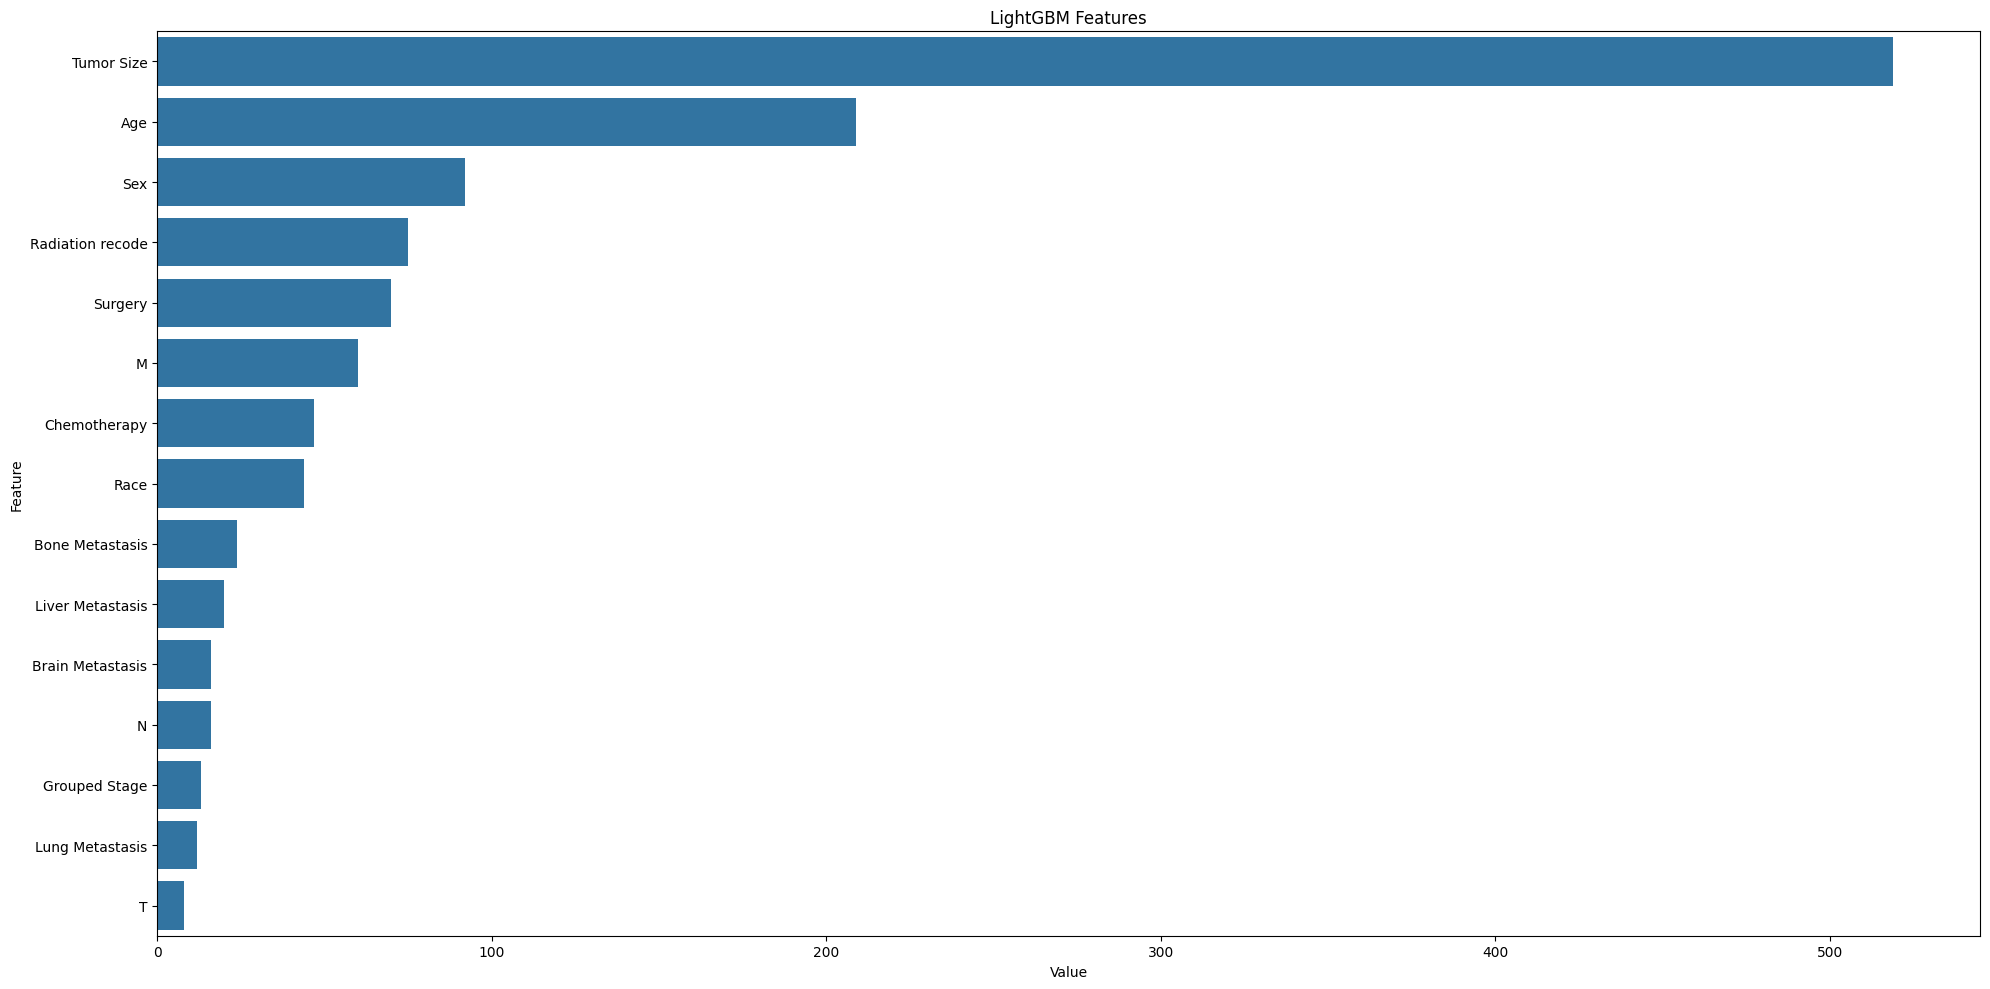

In [121]:
# plot feature importance sorted from highest to lowest
feature_imp = pd.DataFrame(sorted(zip(auto_best_lgb_model.feature_importances_, X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()